# Quick Start

In this session, we will explore:

- a forecast task on iclaims dataset
- a simple Bayesian ETS Model using `PyStan`
- tools to visualize the forecast

## Load Library

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import ETS
from orbit.diagnostics.plot import plot_predicted_data

In [2]:
print(orbit.__version__)

1.1.1


## Data

The *iclaims* data contains the weekly initial claims for US unemployment benefits against a few related google trend queries (unemploy, filling and job)from Jan 2010 - June 2018. 
This aims to demo a similar dataset from the Bayesian Structural Time Series (BSTS) model [(Scott and Varian 2014)](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while regressors such as google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).

**Note:** Both the response and regressors are transformed by log in order to illustrate a multiplicative model.  We will continue to use this dataset in some subsequent sections.

In [3]:
# load data
df = load_iclaims()
date_col = 'week'
response_col = 'claims'
df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [4]:
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


### Train / Test Split

In [5]:
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]

## Forecasting Using Orbit

`Orbit` aims to provide an intuitive **initialize-fit-predict** interface for working with forecasting tasks. Under the hood, it utilizes probabilistic modeling API such as
`PyStan` and `Pyro`. We first illustrate a Bayesian implementation of Rob Hyndman's ETS (which stands for Error, Trend, and Seasonality) Model [(Hyndman et. al, 2008)](http://www.exponentialsmoothing.net/home) using `PyStan`.

In [6]:
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [7]:
%%time
ets.fit(df=train_df)

CPU times: user 278 ms, sys: 51.9 ms, total: 330 ms
Wall time: 1.37 s


In [8]:
predicted_df = ets.predict(df=test_df)

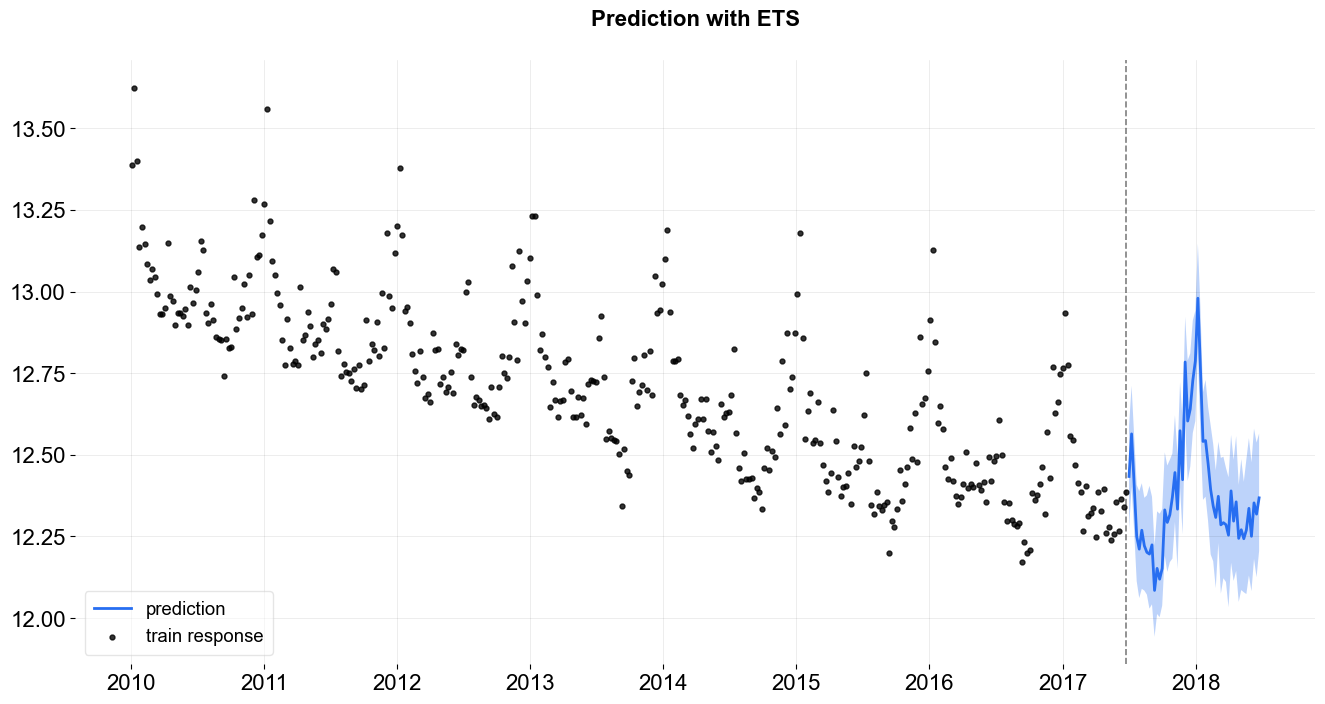

In [9]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, title='Prediction with ETS')

## Extract and Analyze Posterior Samples

We can use `.get_posterior_samples()` to extract posterior samples in an `OrderedDict` format.

In [10]:
posterior_samples = ets.get_posterior_samples()
posterior_samples.keys()

odict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])

We can also plot the extracted parameters posteriors with [arviz](https://github.com/arviz-devs/arviz). 

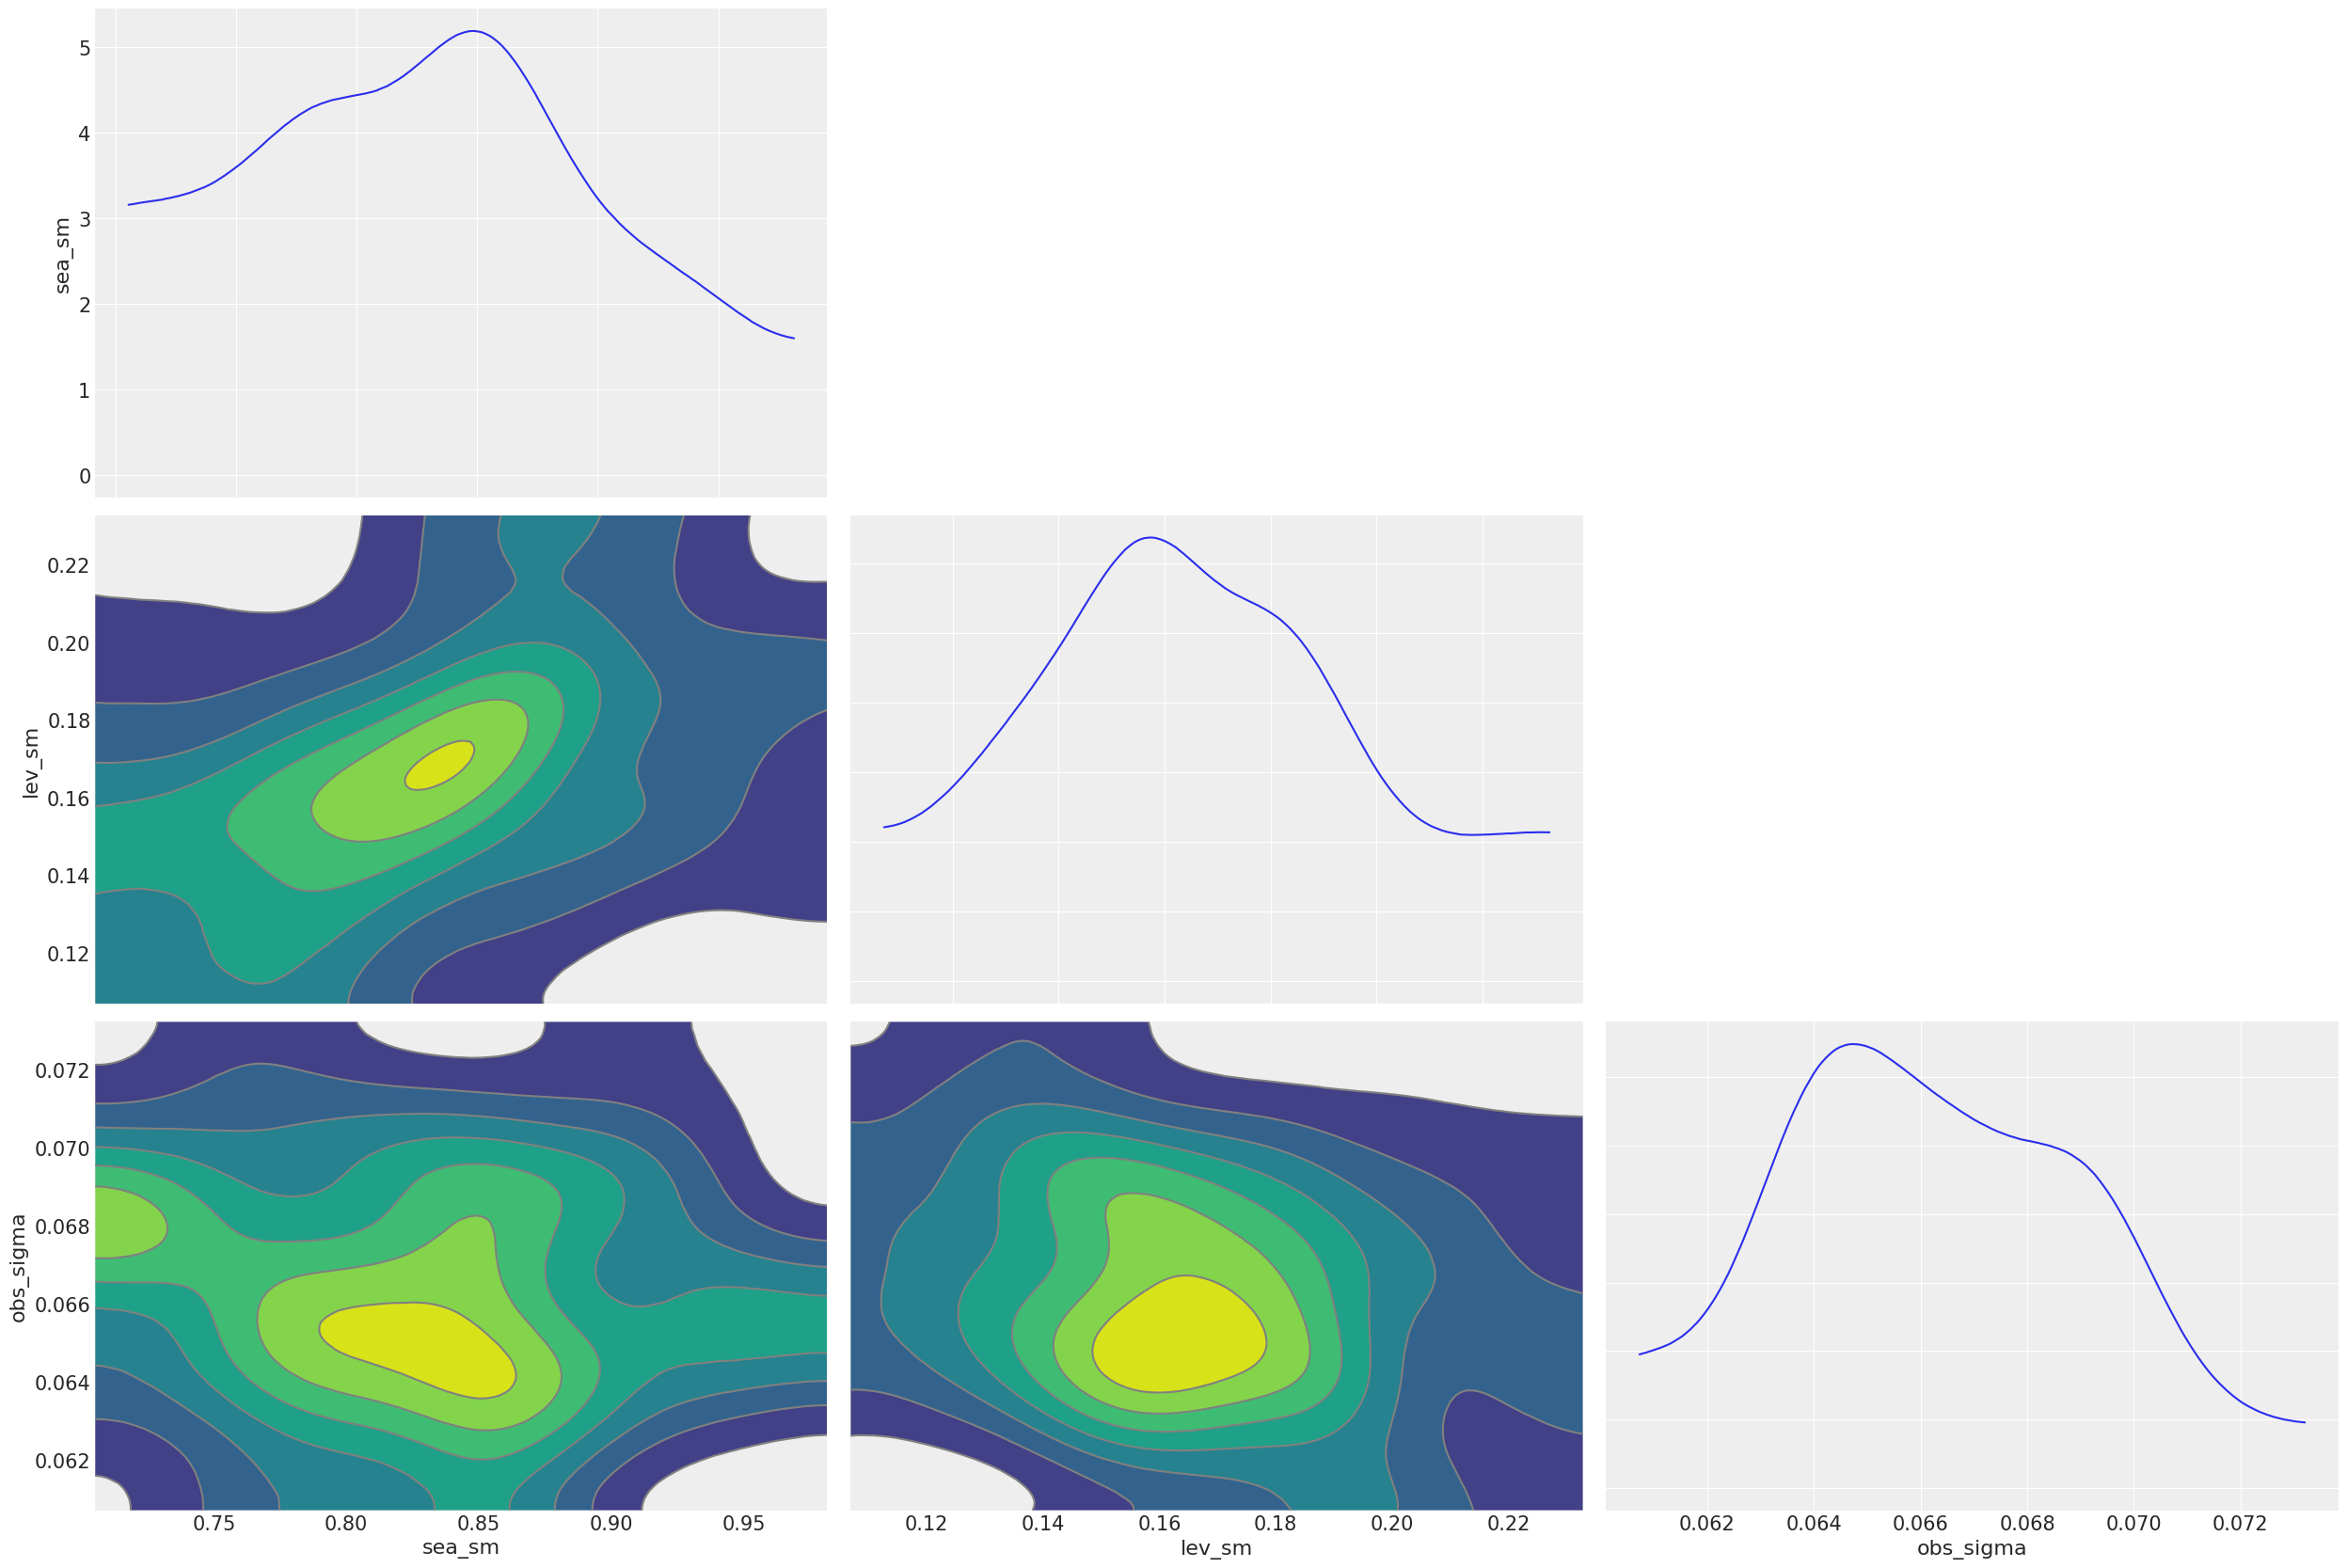

In [11]:
import arviz as az

posterior_samples = ets.get_posterior_samples(permute=False)

# example from https://arviz-devs.github.io/arviz/index.html
az.style.use("arviz-darkgrid")
az.plot_pair(
    posterior_samples,
    var_names=["sea_sm", "lev_sm", "obs_sigma"],
    kind="kde",
    marginals=True,
    textsize=15,
)
plt.show()

For more details in model diagnostics visualization, there is a subsequent section dedicated to it.